# Multilingual Toxic Comment Classification Bert

## Helpful Downloads and Installation

In [1]:
!git clone https://github.com/shadab4150/tez.git

Cloning into 'tez'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 320 (delta 164), reused 218 (delta 75), pack-reused 0
Receiving objects: 100% (320/320), 56.20 KiB | 4.68 MiB/s, done.
Resolving deltas: 100% (164/164), done.


In [1]:
tez_path = '/content/tez/'
import sys
sys.path.append(tez_path)

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 74 bytes


In [4]:
!pip uninstall kaggle -y
!pip install -qq kaggle

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10
     |████████████████████████████████| 61kB 3.2MB/s 


In [5]:
!kaggle competitions download -c jigsaw-multilingual-toxic-comment-classification

 99% 1.06G/1.08G [00:08<00:00, 120MB/s]
100% 1.08G/1.08G [00:08<00:00, 144MB/s]


In [6]:
!unzip '/content/jigsaw-multilingual-toxic-comment-classification.zip' -d '/content/jigsaw'

Archive:  /content/jigsaw-multilingual-toxic-comment-classification.zip
  inflating: /content/jigsaw/jigsaw-toxic-comment-train-processed-seqlen128.csv  
  inflating: /content/jigsaw/jigsaw-toxic-comment-train.csv  
  inflating: /content/jigsaw/jigsaw-unintended-bias-train-processed-seqlen128.csv  
  inflating: /content/jigsaw/jigsaw-unintended-bias-train.csv  
  inflating: /content/jigsaw/sample_submission.csv  
  inflating: /content/jigsaw/test-processed-seqlen128.csv  
  inflating: /content/jigsaw/test.csv  
  inflating: /content/jigsaw/validation-processed-seqlen128.csv  
  inflating: /content/jigsaw/validation.csv  


In [7]:
!pip install -qq transformers

     |████████████████████████████████| 1.8MB 5.5MB/s 
     |████████████████████████████████| 3.2MB 18.5MB/s 
     |████████████████████████████████| 890kB 31.7MB/s 


## Importing Libraries

In [2]:
import tez
import transformers
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [4]:
trn_df = pd.read_csv('/content/jigsaw/jigsaw-toxic-comment-train.csv')

In [5]:
path = Path('/content/jigsaw')

In [6]:
trn_df.sample(n=5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
49749,8502348456b091de,Please don't block me - I only explained my do...,0,0,0,0,0,0
214051,d97e74101cec931a,== Captain John Geddes == \n\n Cameron has spo...,0,0,0,0,0,0
169898,29782d811ab51c01,"How about if you watch the movie, dumbass? The...",1,0,1,0,1,0
172821,34c7bbedc911a8a2,""", 14 May 2008 (UTC) \n\n In addition to Berna...",0,0,0,0,0,0
219883,f0e6fe81108afc20,""" \n\n == Why...? == \n\n Okay, this is probab...",0,0,0,0,0,0


## Stratified KFOLD

In [7]:
from sklearn.model_selection import StratifiedKFold

In [8]:
trn_df['kfold'] = -1
trn_df = trn_df.sample(frac=1.)
y = trn_df['toxic'].values
skf = StratifiedKFold(n_splits=10)
for fld, (trn_,val_) in enumerate(skf.split(X=trn_df,y=y)):
    trn_df.loc[val_,'kfold'] = fld

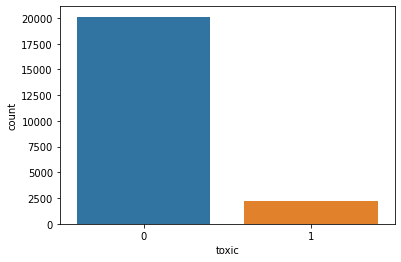

In [9]:
sns.countplot(x=trn_df[trn_df.kfold==1].toxic);

## Cleaning the Text

In [10]:
import re
import nltk
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')

def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        text = [w for w in text if not w in STOPWORDS]
    
    text = " ".join(text)
    
    # Remove punctuation from text
    # text = "".join([c for c in text if c not in punctuation])

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    # text = re.sub(r"\0s", "0", text) # It doesn't make sense to me
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df = trn_df[trn_df.kfold<=3].copy()

In [12]:
df['comment_text'] = df['comment_text'].apply(lambda x: text_to_wordlist(x, remove_stopwords=False))

In [13]:
df.sample(n=10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,kfold
76146,cbd508def77561f3,speedy deletion of harry hasso a tag has been...,0,0,0,0,0,0,3
45191,78da45ef2dc74b62,i see there a protocol and i cannot keep this...,0,0,0,0,0,0,2
46002,7aea6754f3e65ca5,lol glad to have helped,0,0,0,0,0,0,2
39047,6830731e85e32fa1,wikify i have begun wikifying this article ins...,0,0,0,0,0,0,1
27512,48cf4e824ff9ab27,thank you for experimenting with the page chic...,0,0,0,0,0,0,1
86353,e6f4221276af7c4d,matter to me i am classy ! ;,0,0,0,0,0,0,3
7524,140161b98b2370ab,much appreciated talk,0,0,0,0,0,0,0
25244,42d44bb3b76acfe0,not yet - every time i click on it it tells me...,0,0,0,0,0,0,1
51426,8991e9f485fa8a42,sockpuppetry case your name has been mentione...,0,0,0,0,0,0,2
37820,64f5cdeb0f25b50b,12 october 2007 utc absolutely as long as tha...,0,0,0,0,0,0,1


## DataLoader

In [14]:
from transformers import AdamW,get_linear_schedule_with_warmup
import sklearn.metrics as sklm

In [106]:
class BERTDataset:
    def __init__(self, texts, targets,max_len=64):
        self.texts = texts
        self.targets = targets
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-cased",
            do_lower_case=False
        )
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self,idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True
            )
        resp = {
            "ids" :  torch.tensor(inputs["input_ids"],dtype=torch.long),
            "mask" : torch.tensor(inputs["attention_mask"],dtype=torch.long),
            "token_type_ids" : torch.tensor(inputs["token_type_ids"],dtype=torch.long),
            "targets" : torch.tensor(self.targets[idx],dtype=torch.float)
        }

        return resp

## MultiLingualText Model

In [107]:
class TextModel(tez.Model):
    def __init__(self,num_classes,num_train_steps):
        super().__init__()
        self.bert = transformers.BertForSequenceClassification.from_pretrained("bert-base-cased",return_dict=False,num_labels=1)
        #self.bert_drop = nn.Dropout(0.2)
        #self.out = nn.Linear(768,num_classes)
        self.num_train_steps = num_train_steps
        self.step_scheduler_after = "batch"
        

    def fetch_optimizer(self):
        opt = AdamW(self.parameters(),lr=1e-4)
        return opt

    def fetch_scheduler(self):
        sch = get_linear_schedule_with_warmup(
            self.optimizer,num_warmup_steps=0,num_training_steps=self.num_train_steps
            )
        return sch

    def loss(self,outputs,targets):
        return nn.BCEWithLogitsLoss()(outputs,targets.view(-1,1))

    def monitor_metrics(self,outputs,targets):
        outputs = outputs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        acc = sklm.accuracy_score(targets,outputs>=0.5)
        try:
            res = sklm.roc_auc_score(targets,outputs)
        except:
            res = 0.5 
        return {"rocauc":res,"accuracy":acc}

    def forward(self,ids,mask,token_type_ids,targets=None):
        _,x = self.bert(ids,attention_mask=mask,token_type_ids=token_type_ids,labels=targets)
        #x = self.bert_drop(x)
        #x = self.out(x)
        if targets is not None:
            loss = self.loss(x,targets)
            met = self.monitor_metrics(x,targets)
            return x, loss, met
        return x,-1, {}

In [108]:
df_train = df[df.kfold!=0].reset_index(drop=True)
df_valid = df[df.kfold==0].reset_index(drop=True)

In [109]:
df_valid.toxic.value_counts()

0    20181
1     2174
Name: toxic, dtype: int64

In [110]:
train_dataset = BERTDataset(df_train.comment_text.values,df_train.toxic.values)
valid_dataset = BERTDataset(df_valid.comment_text.values,df_valid.toxic.values)

In [111]:
TRAIN_BS  = 32
EPOCHS = 10

In [112]:
n_train_steps = int(len(df_train) / TRAIN_BS* EPOCHS)

In [113]:
n_train_steps

20957

In [114]:
model = TextModel(num_classes=1,num_train_steps=n_train_steps)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [115]:
es = tez.callbacks.EarlyStopping(monitor="valid_loss", model_path="model.bin")

In [ ]:
model.fit(train_dataset,
          valid_dataset=valid_dataset,
          device="cuda",
          epochs=10, 
          callbacks=[es],
          train_bs=32,
          fp16=True)


Validation score improved (inf --> 0.3248936812765097). Saving model!


In [ ]:
model = None
import gc
gc.collect()